# Produce conditional distributions in 5 regions.

Regions defined by MCS data:

* MCS core
* MCS shield
* cloud core
* cloud shield
* env

Areas are mutually exclusive - MCS core and MCS shield do not overlap. Results from here used for EGU talk.

* 19/5/23: Copy from [conditional_dist_exploratory](conditional_dist_exploratory.ipynb)

In [1]:
import datetime as dt
from itertools import product
from pathlib import Path

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import dask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS
from mcs_prime import plotting as mplt

from remake import load_remake

In [2]:
era5_hists = load_remake('../../remakefiles/era5_histograms.py')

## Load data in from files

N.B. gridpoint files have to be concatted together on a high-mem node on SLURM as it takes almost 500G of mem to do this!

In [3]:
# Hourly dataset. This has one distribution / hr over all gridpoints conditional on the 5 regions.
dsh = xr.open_mfdataset([t.outputs['hist'] for t in  era5_hists.ConditionalERA5HistHourly.tasks.filter(core_method='tb')]).load()
dshp = xr.open_mfdataset([t.outputs['hist'] for t in  era5_hists.ConditionalERA5HistHourly.tasks.filter(core_method='precip')]).load()

In [4]:
# Gridpoint dataset. This has one distribution / gridpoint over one year conditional on the 5 regions.
# This has already been summed on SLURM because it's highly compressed on disk; uncompressed each one is quite large
# and it takes a lot of memory to concat them.
dsgp = xr.open_dataset(era5_hists.CombineConditionalERA5HistGridpoint.tasks[-1].outputs['hist'])

In [5]:
# Meanfield dataset. Same as hourly, but instead of the env CAPE etc., it uses the mean (over one year currently)
# CAPE. I.e. it looks at where e.g. each MCS mask is, and takes the mean CAPE at those locations.
dsmf = xr.open_mfdataset([t.outputs['hist'] for t in era5_hists.ConditionalERA5HistMeanfield.tasks]).load()

In [6]:
LS_REGIONS = ['all', 'land', 'ocean']
def load_lsmask(path):
    lsmask = {}
    for lsreg in LS_REGIONS:
        # Build appropriate land-sea mask for region.
        da_lsmask = xr.load_dataarray(path)
        if lsreg == 'all':
            # All ones.
            lsmask['all'] = da_lsmask[0].sel(latitude=slice(60, -60)).values >= 0
        elif lsreg == 'land':
            # LSM has land == 1.
            lsmask['land'] = da_lsmask[0].sel(latitude=slice(60, -60)).values > 0.5
        elif lsreg == 'ocean':
            # LSM has ocean == 0.
            lsmask['ocean'] = da_lsmask[0].sel(latitude=slice(60, -60)).values <= 0.5
        else:
            raise ValueError(f'Unknown region: {lsreg}')
    return lsmask
lsmask = load_lsmask(era5_hists.ConditionalERA5HistHourly.tasks[0].inputs['ERA5_land_sea_mask'])

In [7]:
# Sanity check on data - this should be true of each var:
for v, reg in product(['cape', 'tcwv'], ['MCS_core', 'MCS_shield', 'cloud_core', 'cloud_shield', 'env']):
    print(v, reg)
    assert (dsgp[f'{v}_{reg}'].sum(dim=['latitude', 'longitude']).values == dsh[f'all_{v}_{reg}'].sum(dim='time').values).all()

cape MCS_core
cape MCS_shield
cape cloud_core
cape cloud_shield
cape env
tcwv MCS_core
tcwv MCS_shield
tcwv cloud_core
tcwv cloud_shield
tcwv env


## MCS convection given any convection

This is effectively what I was doing by eye in the [below full distributions](#Full-probablility-distributions) - take the two convective regions (MCS and cloud) and work out the probability of being in the MCS convective region given that you are in either of the convective regions. I.e. p(MCS conv|conv).

In [8]:
def plot_hourly_hists(ds):
    for v in ['cape', 'tcwv', 'vimfd']:
        fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
        #ax = plt.gca()
        #ax2 = ax.twinx()
        
        ax.set_title(v.upper())
        for lsreg in ['all', 'land', 'ocean']:
            d1 = ds[f'{lsreg}_{v}_MCS_core'].sum(dim='time').values
            d2 = ds[f'{lsreg}_{v}_cloud_core'].sum(dim='time').values
            d3 = ds[f'{lsreg}_{v}_MCS_shield'].sum(dim='time').values
            d4 = ds[f'{lsreg}_{v}_cloud_shield'].sum(dim='time').values
            d5 = ds[f'{lsreg}_{v}_env'].sum(dim='time').values
            dt = d1 + d2 + d3 + d4 + d5
            
            with np.errstate(invalid='ignore', divide='ignore'):
                d = d1 / (d1 + d2)
        
            p = ax.plot(ds[f'{v}_hist_mids'].values, d, label=lsreg)
            ax2.plot(ds[f'{v}_hist_mids'].values, dt / dt.sum(), label=lsreg, color=p[0].get_color(), linestyle='--')

            if v == 'cape':
                plt.xlabel('J kg$^{-1}$')
                plt.xlim((0, 5000))
            elif v == 'tcwv':
                plt.xlabel('mm')
                plt.xlim((0, 100))
            elif v == 'vimfd':
                plt.xlabel('kg m$^{-2}$ s$^{-1}$')
                plt.xlim((-0.002, 0.002))
        ax.set_ylabel('p(MCS conv|conv)')
        ax2.set_ylabel('pdf')

        ax.set_ylim((0, 1))
        ax2.set_ylim((0, None))

        ax.legend()

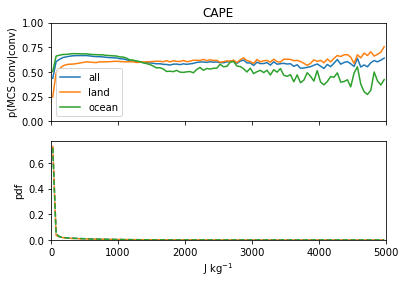

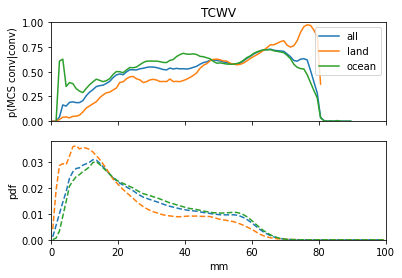

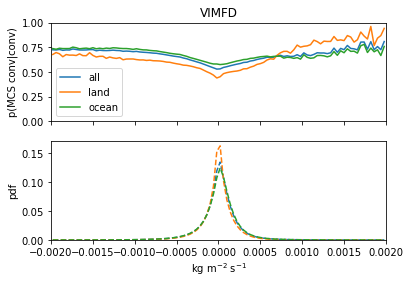

In [9]:
plot_hourly_hists(dsh)

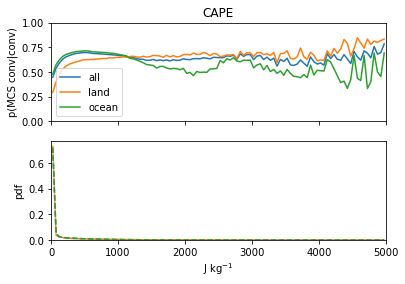

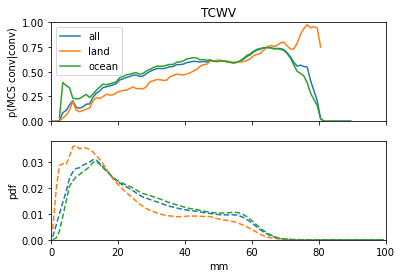

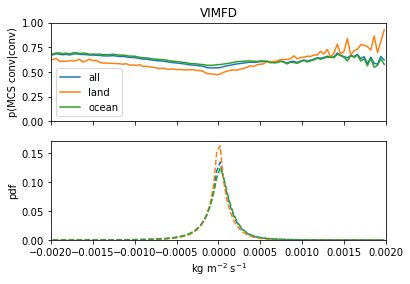

In [10]:
plot_hourly_hists(dshp)

This shows the probability of MCS convection given *any* convection, for the contemperaneous CAPE distributions in the two convective regions. As noted below and in EGU talk, probability is not a strong function of CAPE. I.e. CAPE is a bad predictor of whether or not given convection will be MCS convection. This is particularly true over land, where the probability is 0.6 for all values of CAPE. This could perhaps serve as a baseline probability.

For TCWV, the probability is quite a strong function of TCWV. Approximately, it is a linear function of TCWV, going from ~0 to 0.7 for "all". I need to relate this to previous work on TCWV and precipitation relationships...

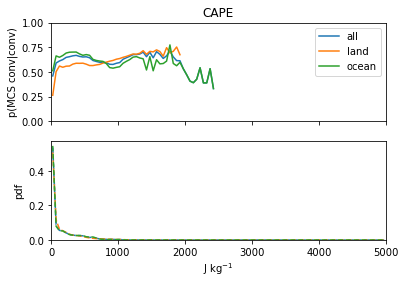

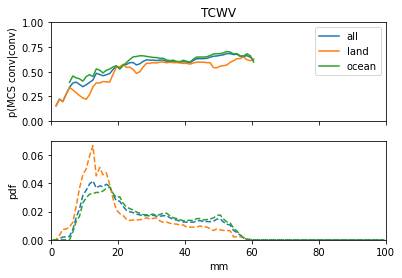

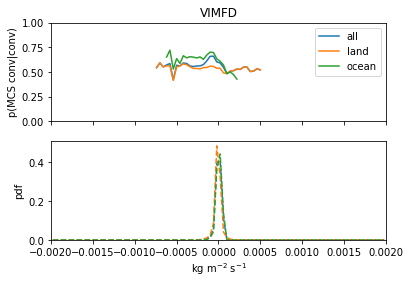

In [11]:
plot_hourly_hists(dsmf)

This shows the same as above, but for the mean field of CAPE/TCWV. Essentially, this captures the effect of the change in location of the different convective regions, but not the change in the local conditions. Most noticeable is that the max x value on both graphs is a lot lower - this makes sense because clearly the mean field for both is going to lose the maximum (and minimum) values. The distributions are mainly similar - CAPE is around 0.6 for all values of CAPE, and there is a slight oceaninc peak at lower values of CAPE. TCWV shows an increas up to about 30 mm, with a leveling out after. There is a reduced difference between land and ocean between 20-40 mm, and not much sign of the increase above 50 mm.

Taken together, these mean that a large degree of the distributions can be explained by where the different types of convection are appearing, and that the local conditions where the convection is may not be so important. However, to get useful information in the region above 60 mm, we need to consider the full contemporaneous fields.

### Gridcell analysis

Start of with a sanity check. The hourly analysis above is computed by summing over latitude and longitude for each hour, then summing over all the hours. The gridpoint analysis below is computed by summing over all hours for each gridpoint. If I then sum over all gridpoints (applying the land/sea mask) then I should get identical results. I do!

In [12]:
def plot_gridpoint_hists(ds, regmask):
    for v in ['cape', 'tcwv', 'vimfd']:
        plt.figure()
        plt.title(v.upper())
        for lsreg in ['all', 'land', 'ocean']:
            d1 = ds[f'{v}_MCS_core'].values
            d2 = ds[f'{v}_cloud_core'].values
            d1 = (d1 * lsmask[lsreg][:, :, None]).sum(axis=(0, 1))
            d2 = (d2 * lsmask[lsreg][:, :, None]).sum(axis=(0, 1))
            with np.errstate(invalid='ignore', divide='ignore'):
                d = d1 / (d1 + d2)
            plt.plot(ds[f'{v}_hist_mids'].values, d, label=lsreg)
        if v == 'cape':
            plt.xlabel('J/kg')
        elif v == 'tcwv':
            plt.xlabel('mm')
        plt.ylabel('p(MCS conv|conv)')
        plt.ylim((0, 1))
        plt.legend()


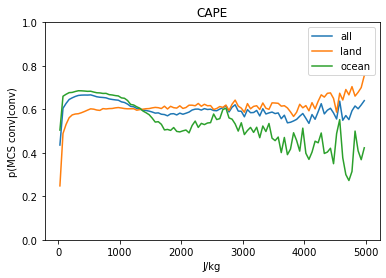

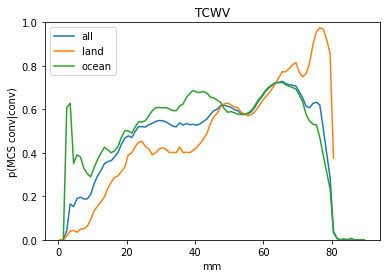

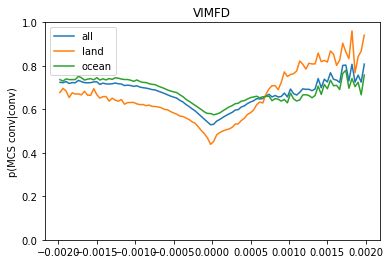

In [13]:
# This should be identical to plot_hourly_hists(dsh) (it is).
# They are summing over different dimensions at different times. 
plot_gridpoint_hists(dsgp, lsmask)

With the different gridpoint information, it is possible to calculate a conditional PDF over some small region, defined below by `step`, i.e. a number of ERA5 gridpoints. The defult value of 16 means that each region is 4deg x 4deg (0.25deg resolution). The distribution of distributions (yes, I know, confusing) can then be calculated. First, the median and interquartile range are shown, then the full distributions are shown.

In [14]:
def plot_gridpoint_prob_dist(ds, pmin=25, pmax=75, step=16):
    for v in ['cape', 'tcwv', 'vimfd']:
        plt.figure()
        plt.title(v.upper())
        d1 = ds[f'{v}_MCS_core'].coarsen(latitude=step, longitude=step, boundary='trim').sum().values
        d2 = ds[f'{v}_cloud_core'].coarsen(latitude=step, longitude=step, boundary='trim').sum().values
        with np.errstate(invalid='ignore', divide='ignore'):
            d = d1 / (d1 + d2)
        dmin, d50, dmax = np.nanpercentile(d, [pmin, 50, pmax], axis=(0, 1))
    
        plt.plot(ds[f'{v}_hist_mids'].values, d50, 'b-')
        plt.plot(ds[f'{v}_hist_mids'].values, dmin, 'b-', alpha=0.7)    
        plt.plot(ds[f'{v}_hist_mids'].values, dmax, 'b-', alpha=0.7)
        plt.fill_between(ds[f'{v}_hist_mids'].values, dmin, dmax, color='b', alpha=0.3)    

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


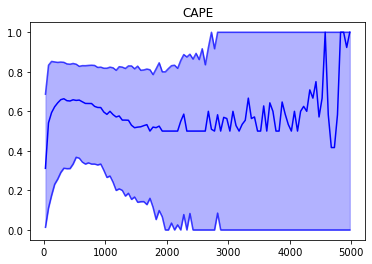

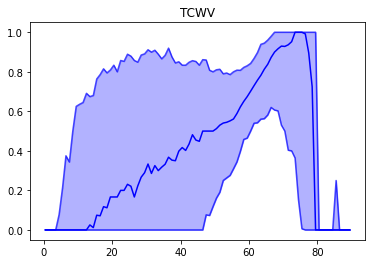

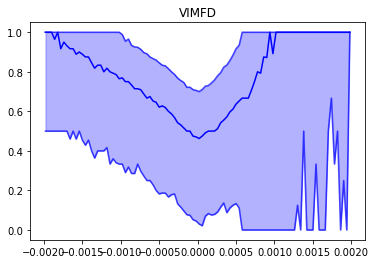

In [15]:
plot_gridpoint_prob_dist(dsgp)

The median for CAPE is close to the value calculated above. CAPE shows a large spread at all values. It is smallest at around 500 J/kg, when it has an IQ range of 0.45 of p(MCS conv|conv). This spread increases to the point that it spans the full range of 0-1 by around 3000 J/kg.

The median for TCWV is close to a linear relationship, starting at 0 at about 10 mm and increasing to 1 by 75 mm. The spread is far larger at lower values of TCWV, with max. spread ~0.9 at around 30 mm. There is a marked decrease in spread (particularly at the lower bound of the IQ range) from around 50-65 mm. 

In [16]:
def plot_gridpoint_2d_prob_dist(ds, pmin=25, pmax=75, step=16):
    nbin = 21
    for v in ['cape', 'tcwv', 'vimfd']:
        plt.figure()
        plt.title(v.upper())
        h = np.zeros((len(ds[f'{v}_hist_mids'].values), nbin - 1))
        d1 = ds[f'{v}_MCS_core'].coarsen(latitude=step, longitude=step, boundary='trim').sum().values
        d2 = ds[f'{v}_cloud_core'].coarsen(latitude=step, longitude=step, boundary='trim').sum().values
        with np.errstate(invalid='ignore', divide='ignore'):
            d = d1 / (d1 + d2)
        for i in range(d.shape[2]):
            h[i, :] = np.histogram(d[:, :, i], bins=np.linspace(0, 1, nbin))[0]
        h = h.reshape(-1, len(h) // (nbin - 1), nbin - 1).sum(axis=1)
        if v == 'cape':
            aspect = 5000
        elif v == 'tcwv':
            aspect = 100
        elif v == 'vimfd':
            aspect = 1/300
        plt.imshow(h.T, origin='lower', extent=(ds[f'{v}_hist_mids'].values[0], ds[f'{v}_hist_mids'].values[-1], 0, 1), aspect=aspect)    
        dmin, d50, dmax = np.nanpercentile(d, [pmin, 50, pmax], axis=(0, 1))
    
        plt.plot(ds[f'{v}_hist_mids'].values, d50, 'r-')
        plt.plot(ds[f'{v}_hist_mids'].values, dmin, 'r--', alpha=0.7)    
        plt.plot(ds[f'{v}_hist_mids'].values, dmax, 'r--', alpha=0.7)
    


/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


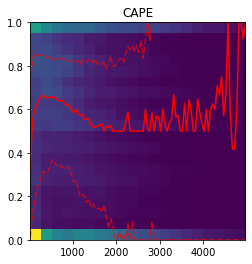

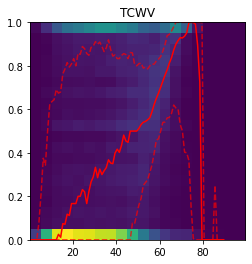

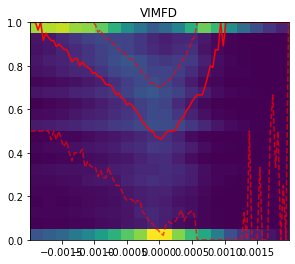

In [17]:
plot_gridpoint_2d_prob_dist(dsgp)

Plotting the full distributions is insightful. At most values of CAPE or TCWV, the distributions have a peak at probabilites of 0 and 1. This means (I think) most regions mainly see one type of convection, with relatively few seeing both (although from the colours near around 0.5, this increases for TCWV above 50 mm). Need to think about this more/show Bob.

In [18]:
def plot_lat_band_hist(ds, latstep=20):
    for v in ['cape', 'tcwv', 'vimfd']:
        plt.figure()
        plt.title(v.upper())
        for latstart in range(60, -51, -latstep):
            d1 = ds[f'{v}_MCS_core'].sel(latitude=slice(latstart, latstart - latstep + 0.25)).values.sum(axis=(0, 1))
            d2 = ds[f'{v}_cloud_core'].sel(latitude=slice(latstart, latstart - latstep + 0.25)).values.sum(axis=(0, 1))
            with np.errstate(invalid='ignore', divide='ignore'):
                d = d1 / (d1 + d2)
            plt.plot(ds[f'{v}_hist_mids'].values, d, label=f'{latstart - latstep / 2} lat')
        if v == 'cape':
            plt.xlabel('J/kg')
        elif v == 'tcwv':
            plt.xlabel('mm')
        plt.ylabel('p(MCS conv|conv)')
        plt.ylim((0, 1))
        plt.legend()

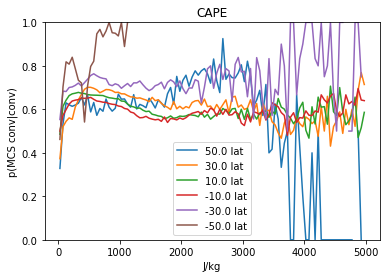

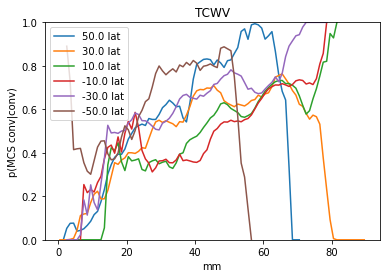

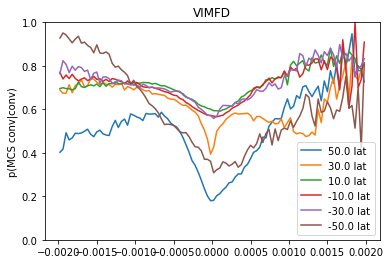

In [19]:
plot_lat_band_hist(dsgp)

Latitudinal variation of distributions. All CAPE distributions show similar to the full distribution apart from 40S-60S (-50). 40S-60S shows a steep increase up to 1 by 1000 J/kg, above which there aren't enough values to compute the distribution. There is a divergence after 3000 J/kg with -30 going to 1 and -50 going to 0, but there are clearly not many datapoints here. The two equatorial latitudes (10 and -10) are closest to the full distribution.

## Regional similarity to global distribution

With the gridpoint information, it is possible to calculate a regional (over e.g. 16x16 ERA5 gridpoints) distribution and compare this to the global distribution. I do this in two ways: using an RMSE and using a bias (integral difference).

In [20]:
def xr_add_cyclic_point(da, lon_name='longitude'):
    """Pad data array in longitude dimension.

    * Taken from https://stackoverflow.com/a/60913814/54557
    * Modified to handle data on model levels as well.
    * Use add_cyclic_point to pad input data.
    * Relies on min lon value in da being 0.

    :param da: xr.DataArray with dimensions including longitude
    :param lon_name: name of longitude dimension in da
    :returns: padded copy of da
    """
    lon_idx = da.dims.index(lon_name)
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.longitude, axis=lon_idx)

    # Copy old coords and modify longitude.
    new_coords = {dim: da.coords[dim] for dim in da.dims}
    new_coords[lon_name] = wrap_lon

    # Generate output DataArray with new data but same structure as input.
    out_da = xr.DataArray(data=wrap_data,
                          name=da.name,
                          coords=new_coords,
                          dims=da.dims,
                          attrs=da.attrs)
    return out_da


In [21]:
def rmse(a, b):
    return np.sqrt(np.nanmean((a[None, None, :] - b)**2, axis=2))

def integral_diff(a, b, dx):
    return np.nansum(b - a[None, None, :], axis=2) * dx

In [22]:
def gen_rmse_integral_diff(ds):
    step = 16
    dataarrays = []
    for v in ['cape', 'tcwv']:
        d1 = ds[f'{v}_MCS_core'].values.sum(axis=(0, 1))
        d2 = ds[f'{v}_cloud_core'].values.sum(axis=(0, 1))
        with np.errstate(invalid='ignore', divide='ignore'):
            d = d1 / (d1 + d2)
        da1 = ds[f'{v}_MCS_core'].coarsen(latitude=step, longitude=step, boundary='trim').sum() 
        da2 = ds[f'{v}_cloud_core'].coarsen(latitude=step, longitude=step, boundary='trim').sum()
            
        d1 = da1.values
        d2 = da2.values
        with np.errstate(invalid='ignore', divide='ignore'):
            dc = d1 / (d1 + d2)
       
        da_rmse = xr.DataArray(
            rmse(d, dc),
            name=f'{v}_rmse',
            dims=['latitude', 'longitude'],
            coords=dict(
                latitude=da1.latitude,
                longitude=da1.longitude,
            )
        )
        da_integral_diff = xr.DataArray(
            integral_diff(d, dc, 1),
            name=f'{v}_integral_diff',
            dims=['latitude', 'longitude'],
            coords=dict(
                latitude=da1.latitude,
                longitude=da1.longitude,
            )
        )
        dataarrays.extend([da_rmse, da_integral_diff])
    return xr.merge([xr_add_cyclic_point(da) for da in dataarrays])



In [23]:
ds_metrics = gen_rmse_integral_diff(dsgp)

/tmp/ipykernel_585/4275064752.py:2: RuntimeWarning: Mean of empty slice
  return np.sqrt(np.nanmean((a[None, None, :] - b)**2, axis=2))
/tmp/ipykernel_585/4275064752.py:2: RuntimeWarning: Mean of empty slice
  return np.sqrt(np.nanmean((a[None, None, :] - b)**2, axis=2))


In [24]:
def plot_global_rmse_bias(ds, v='cape'):
    fig, axes = plt.subplots(2, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
    fig.set_size_inches(20, 10)

    mean_rmse = np.nanmean(ds[f'{v}_rmse'].values)
    axes[0].set_title(f'Mean RMSE={mean_rmse}')
    im0 = axes[0].contourf(ds.longitude, ds.latitude, ds[f'{v}_rmse'], levels=np.linspace(0, 0.8, 9))
    if v == 'cape':
        levels = np.linspace(-50, 50, 11)
    elif v == 'tcwv':
        levels = np.linspace(-30, 30, 7)
        
    plt.colorbar(im0, ax=axes[0])
    
    mean_bias = np.nanmean(ds[f'{v}_integral_diff'].values)
    axes[1].set_title(f'Mean bias={mean_bias}')
    im1 = axes[1].contourf(ds.longitude, ds.latitude, ds[f'{v}_integral_diff'],
                           levels=levels, cmap='bwr')
    plt.colorbar(im1, ax=axes[1])
    
    for ax in axes:
        ax.coastlines()

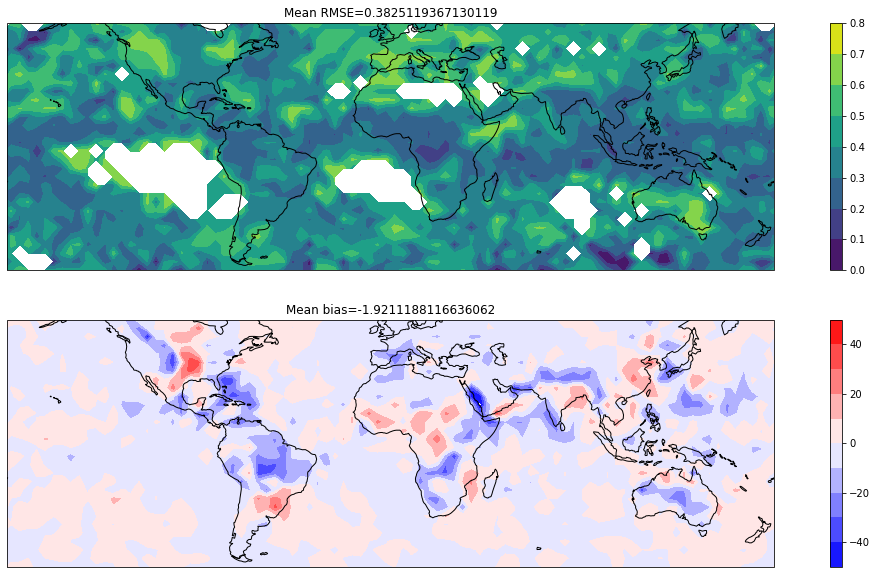

In [25]:
plot_global_rmse_bias(ds_metrics)

The RMSE shows that the regional CAPE distributions are closest to the global distribution near the equator. Regions of high RMSE are: W USA, Iberian peninsulat/N Africa, and SE Australia. The first two are associated with low biases - i.e. there is less chance that an MCS will be detected in these regions than for the global picture for all values of CAPE. Other areas of low bias are the Atlantic off the coast of Florida, the Amazon and close to the Red Sea. High biases are seen over S Brasil, central USA, E China.

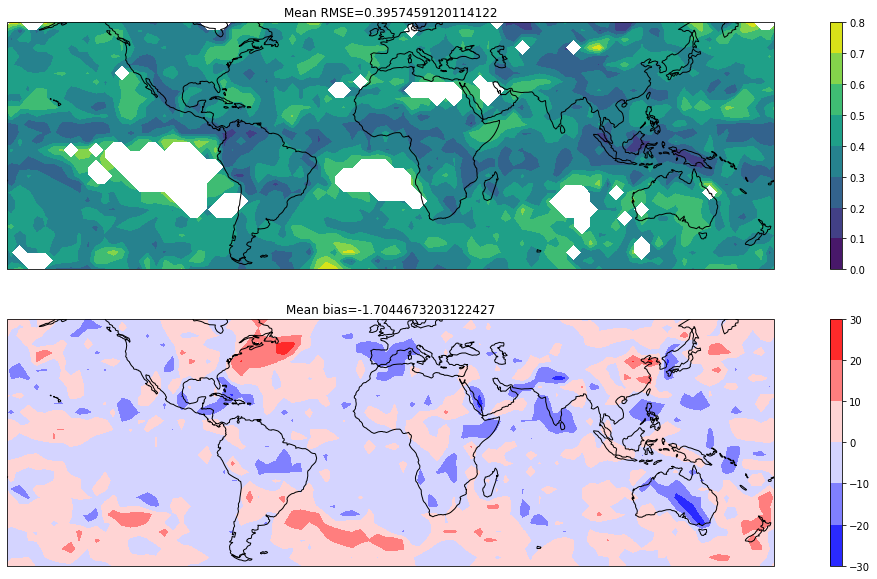

In [26]:
plot_global_rmse_bias(ds_metrics, 'tcwv')

## Full probablility distributions

In [27]:
def calc_xlim(ds, lsreg='all', v='cape', cutoff=0.9999):
    hist = np.array([
        np.nansum(ds[f'{lsreg}_{v}_MCS_core'].values, axis=0),
        np.nansum(ds[f'{lsreg}_{v}_MCS_shield'].values, axis=0),
        np.nansum(ds[f'{lsreg}_{v}_cloud_core'].values, axis=0),
        np.nansum(ds[f'{lsreg}_{v}_cloud_shield'].values, axis=0),
        np.nansum(ds[f'{lsreg}_{v}_env'].values, axis=0),
    ]).sum(axis=0)
    idx = np.where(np.cumsum(hist) / hist.sum() > cutoff)[0][0]
    return hist, (0, ds[f'{v}_hist_mids'].values[idx])

In [28]:
def plot_hist(ds, ax=None, lsreg='all', v='cape', s=None, log=True):
    if s is None:
        if v == 'cape':
            s = slice(0, 500, None)
        elif v == 'tcwv':
            s = slice(0, 101, None)
        elif v[-5:] == 'shear':
            s = slice(0, 101, None)
        elif v == 'vimfd':
            s = slice(0, 101, None)            
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
    def _plot_hist(ds, ax, h, fmt, title):
        bins = ds[f'{v}_bins'].values
        width = bins[1] - bins[0]
        h_density = h / (h.sum() * width)
        ax.plot(ds[f'{v}_hist_mids'].values[s], h_density[s], fmt, label=title);

    ax.set_title(f'{v.upper()} distributions')
    _plot_hist(ds, ax, np.nansum(ds[f'{lsreg}_{v}_MCS_core'].values, axis=0), 'r-', 'MCS core')
    _plot_hist(ds, ax, np.nansum(ds[f'{lsreg}_{v}_MCS_shield'].values, axis=0), 'r--', 'MCS shield')
    _plot_hist(ds, ax, np.nansum(ds[f'{lsreg}_{v}_cloud_core'].values, axis=0), 'b-', 'cloud core')
    _plot_hist(ds, ax, np.nansum(ds[f'{lsreg}_{v}_cloud_shield'].values, axis=0), 'b--', 'cloud shield')
    _plot_hist(ds, ax, np.nansum(ds[f'{lsreg}_{v}_env'].values, axis=0), 'k-', 'env')
    ax.legend()
    if log:
        ax.set_yscale('log')
    if v == 'cape':
        ax.set_xlabel('CAPE (J kg$^{-1}$)')
    elif v == 'tcwv':
        ax.set_xlabel('TCWV (mm)')

In [29]:
def plot_hist_probs(ds, ax=None, lsreg='all', v='cape', s=None):
    if s is None:
        if v == 'cape':
            s = slice(0, 500, None)
        elif v == 'tcwv':
            s = slice(0, 101, None)
        elif v[-5:] == 'shear':
            s = slice(0, 101, None)        
        elif v == 'vimfd':
            s = slice(0, 101, None)      
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        
    counts = np.zeros((5, ds[f'{lsreg}_{v}_MCS_core'].shape[1]))
    counts[0] = np.nansum(ds[f'{lsreg}_{v}_MCS_core'].values, axis=0)
    counts[1] = np.nansum(ds[f'{lsreg}_{v}_MCS_shield'].values, axis=0)
    counts[2] = np.nansum(ds[f'{lsreg}_{v}_cloud_core'].values, axis=0)
    counts[3] = np.nansum(ds[f'{lsreg}_{v}_cloud_shield'].values, axis=0)
    counts[4] = np.nansum(ds[f'{lsreg}_{v}_env'].values, axis=0)
    with np.errstate(invalid='ignore', divide='ignore'):
        probs = counts / counts.sum(axis=0)[None, :]
    
    ax.set_title(f'{v.upper()} probabilities')
    ax.plot(ds[f'{v}_hist_mids'].values[s], probs[0][s], 'r-', label='MCS core')
    ax.plot(ds[f'{v}_hist_mids'].values[s], probs[1][s], 'r--', label='MCS shield')
    ax.plot(ds[f'{v}_hist_mids'].values[s], probs[2][s], 'b-', label='cloud core')
    ax.plot(ds[f'{v}_hist_mids'].values[s], probs[3][s], 'b--', label='cloud shield')
    ax.plot(ds[f'{v}_hist_mids'].values[s], probs[4][s], 'k-', label='env')
    ax.legend()

    if v == 'cape':
        ax.set_xlabel('CAPE (J kg$^{-1}$)')
    elif v == 'tcwv':
        ax.set_xlabel('TCWV (mm)')

In [30]:
def plot_all_dists(ds):
    xlims = {
        ('cape', 'all'): (0, 2000),
        ('cape', 'land'): (0, 2000),
        ('cape', 'ocean'): (0, 2000),
        ('tcwv', 'all'): (0, 73),
        ('tcwv', 'land'): (0, 70),
        ('tcwv', 'ocean'): (0, 73),
    }
    for var in ['cape', 'tcwv']:
        fig, axes = plt.subplots(2, 3)
        fig.set_size_inches((20, 10))
        for ax, lsreg in zip(axes[0], ['all', 'land', 'ocean']):
            plot_hist(ds, ax=ax, lsreg=lsreg, v=var, log=False)
            if var == 'cape':
                ax.set_ylim((0, 0.0015))
                ax.set_title(f'CAPE {lsreg}')
            else:
                ax.set_ylim((0, 0.1))
                ax.set_title(f'TCWV {lsreg}')
            ax.set_xlim(xlims[(var, lsreg)])
                
        for ax, reg in zip(axes[1], ['all', 'land', 'ocean']):
            plot_hist_probs(ds, lsreg=lsreg, v=var, ax=ax)
            if var == 'cape':
                # ax.set_xlim((0, 2500))
                ax.set_title(f'CAPE {lsreg}')
            else:
                ax.set_title(f'TCWV {lsreg}')
            ax.set_xlim(xlims[(var, lsreg)])


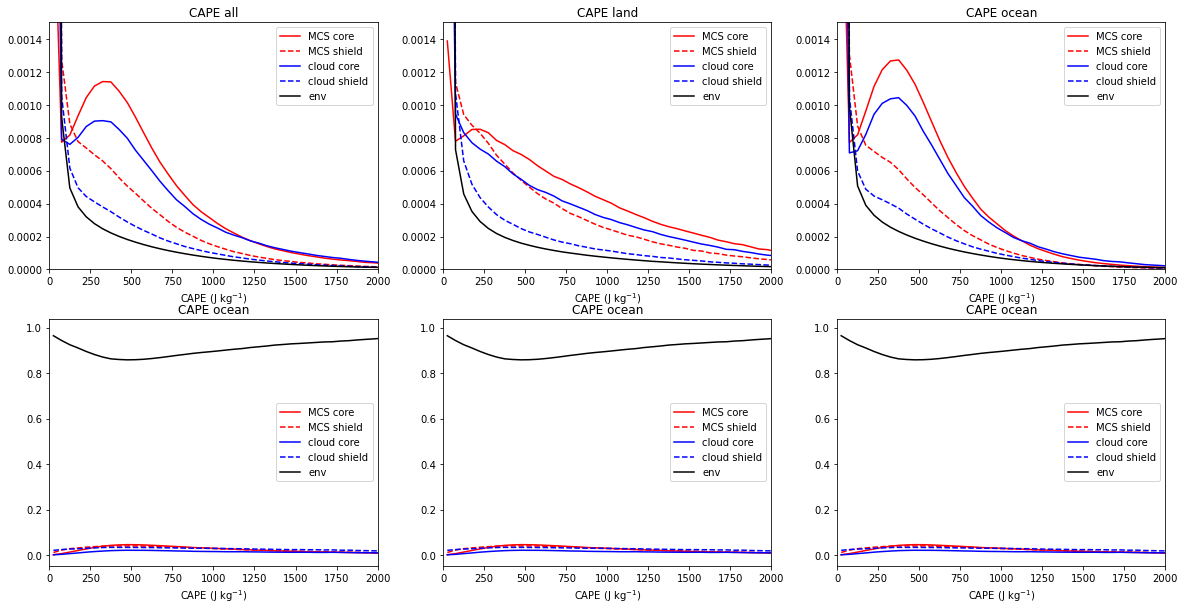

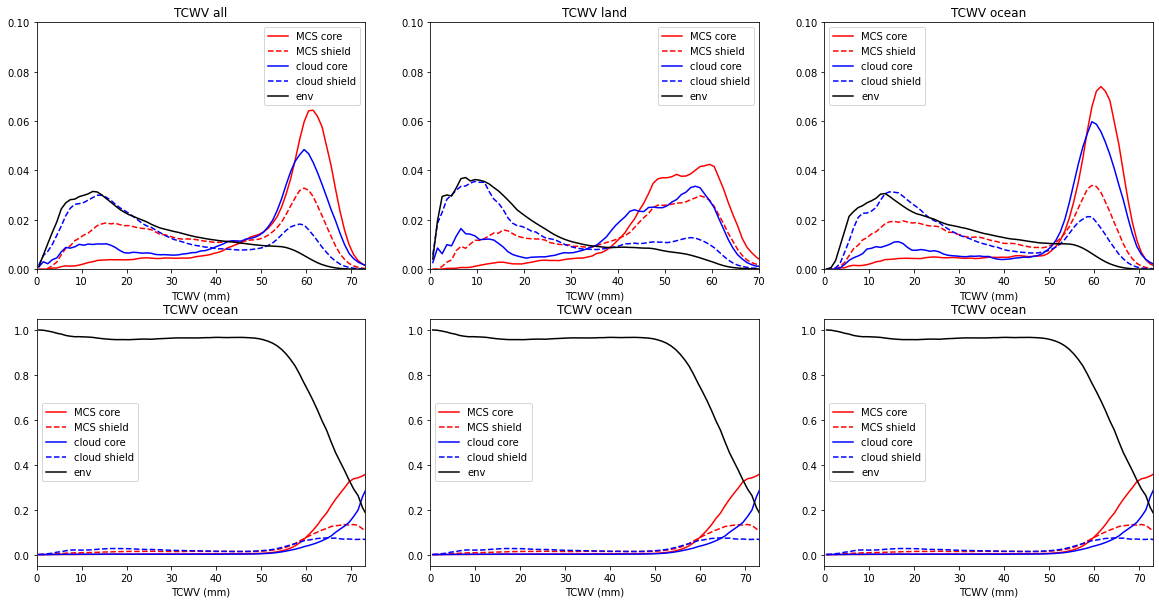

In [31]:
plot_all_dists(dsh)

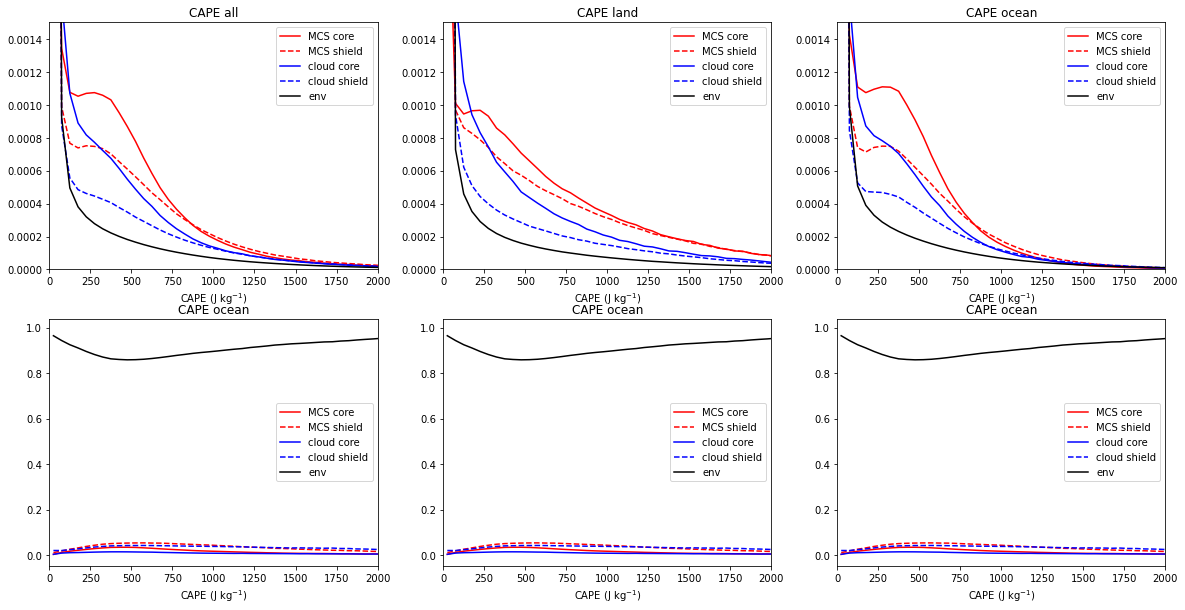

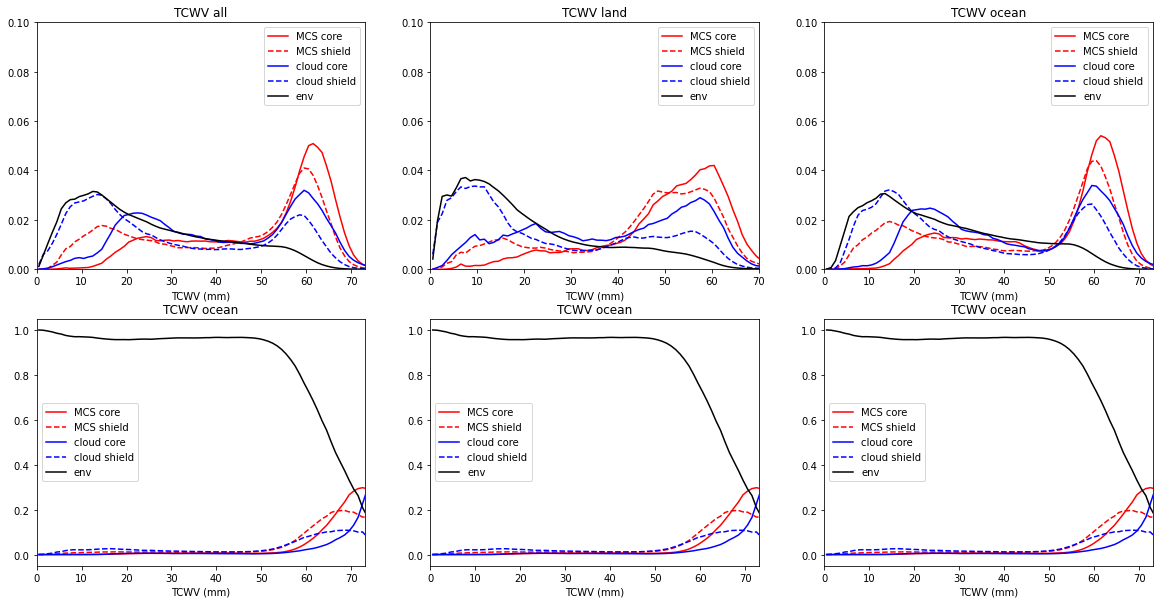

In [32]:
plot_all_dists(dshp)

In [33]:
def plot_shear(ds):
    for var in ['LLS_shear', 'L2M_shear', 'MLS_shear']:
        fig, axes = plt.subplots(2, 3, sharex=True)
        fig.set_size_inches((20, 10))
        for ax, lsreg in zip(axes[0], ['all', 'land', 'ocean']):
            plot_hist(ds, ax=ax, lsreg=lsreg, v=var, log=False)
            ax.set_ylim((0, 0.2))
            ax.set_xlim((0, 30))
                
        for ax, lsreg in zip(axes[1], ['all', 'land', 'ocean']):
            plot_hist_probs(ds, lsreg=lsreg, v=var, ax=ax)
            ax.set_xlim((0, 30))


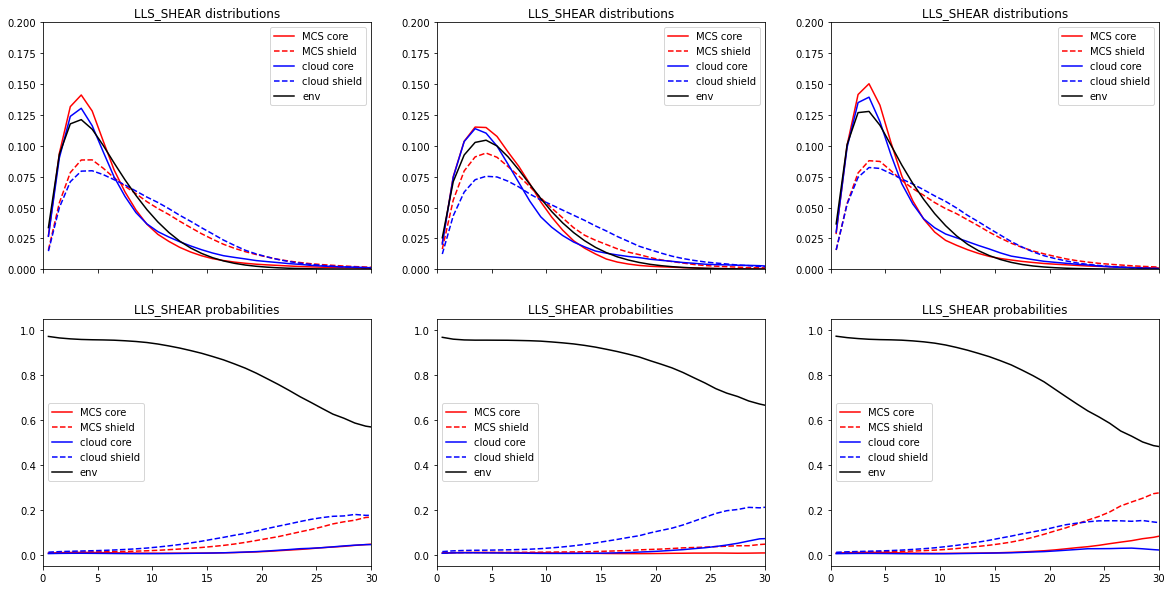

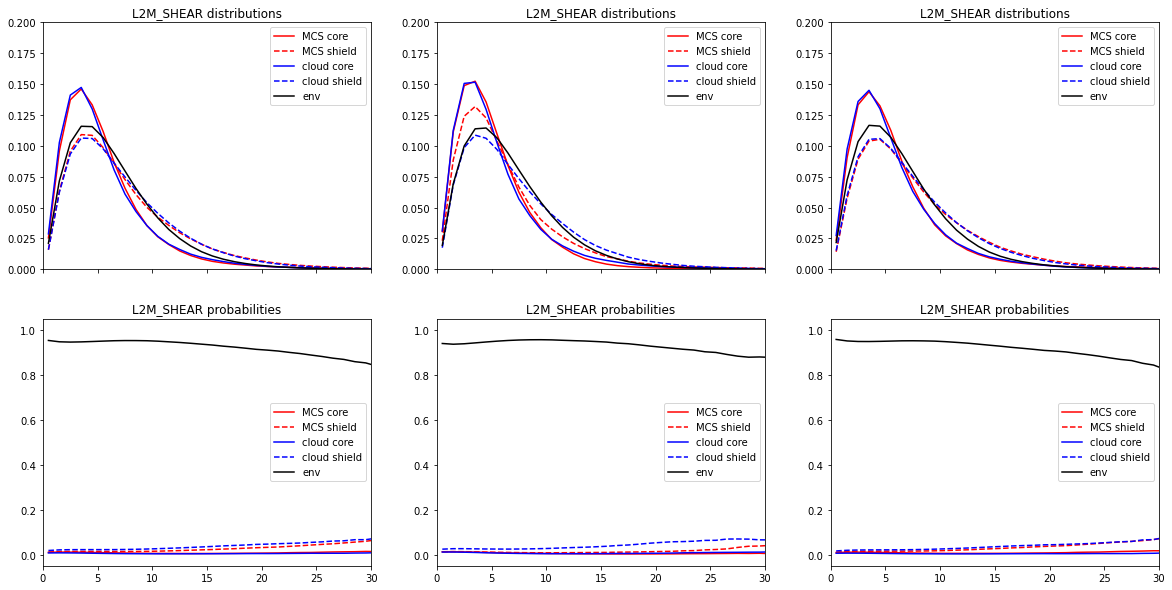

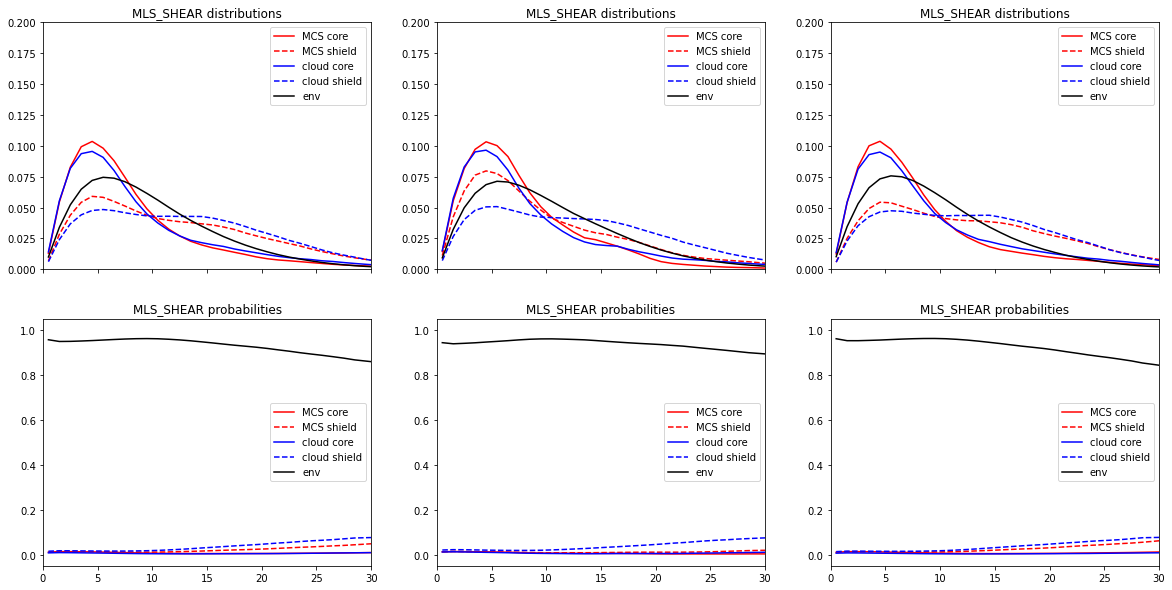

In [34]:
plot_shear(dsh)

In [35]:
def plot_vimfd(ds):
    for var in ['vimfd']:
        fig, axes = plt.subplots(2, 3, sharex=True)
        fig.set_size_inches((20, 10))
        for ax, lsreg in zip(axes[0], ['all', 'land', 'ocean']):
            plot_hist(ds, ax=ax, lsreg=lsreg, v=var, log=False)
            # ax.set_ylim((0, 35e4))
            ax.vlines(x=[0], ymin=0, ymax=35e2)
                
        for ax, reg in zip(axes[1], ['all', 'land', 'ocean']):
            plot_hist_probs(ds, lsreg=lsreg, v=var, ax=ax)
            ax.vlines(x=[0], ymin=0, ymax=1)


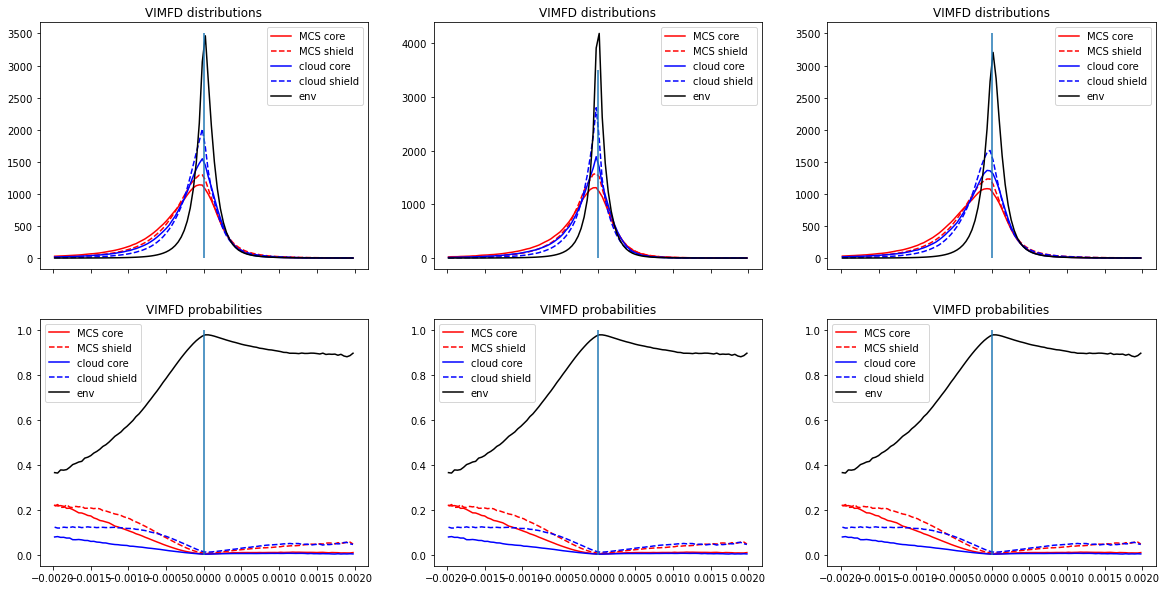

In [36]:
plot_vimfd(dsh)

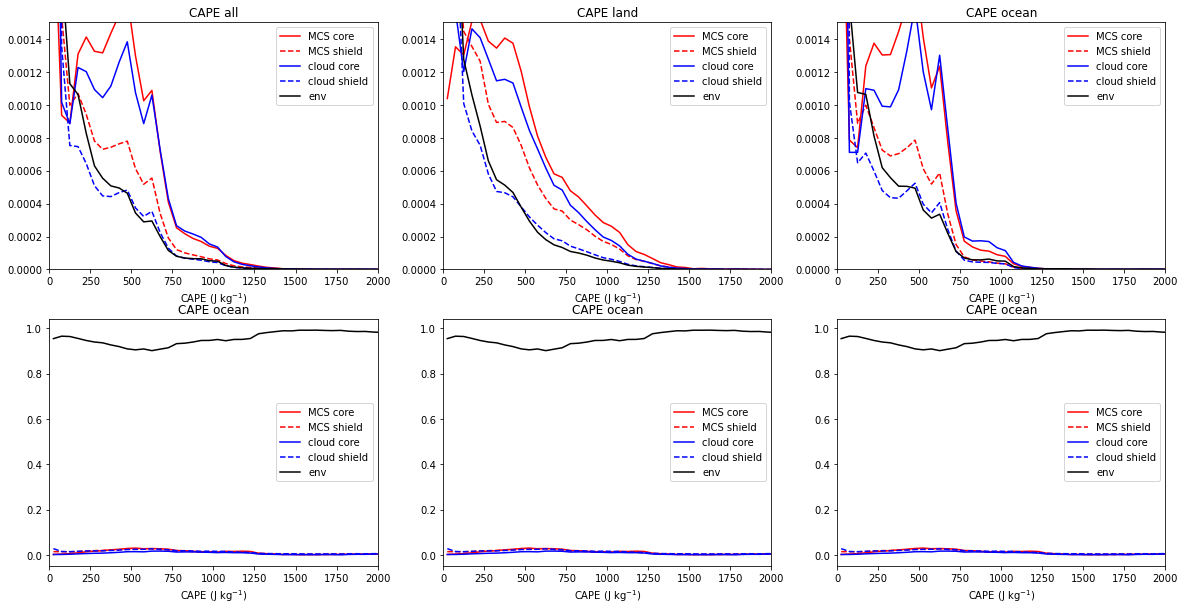

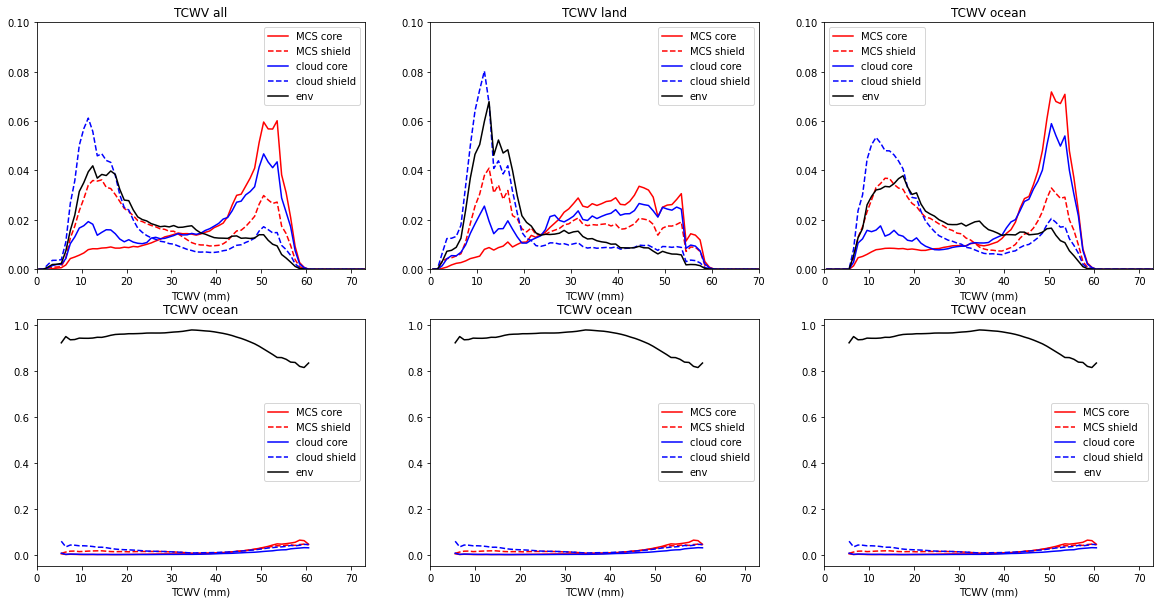

In [37]:
plot_all_dists(dsmf)

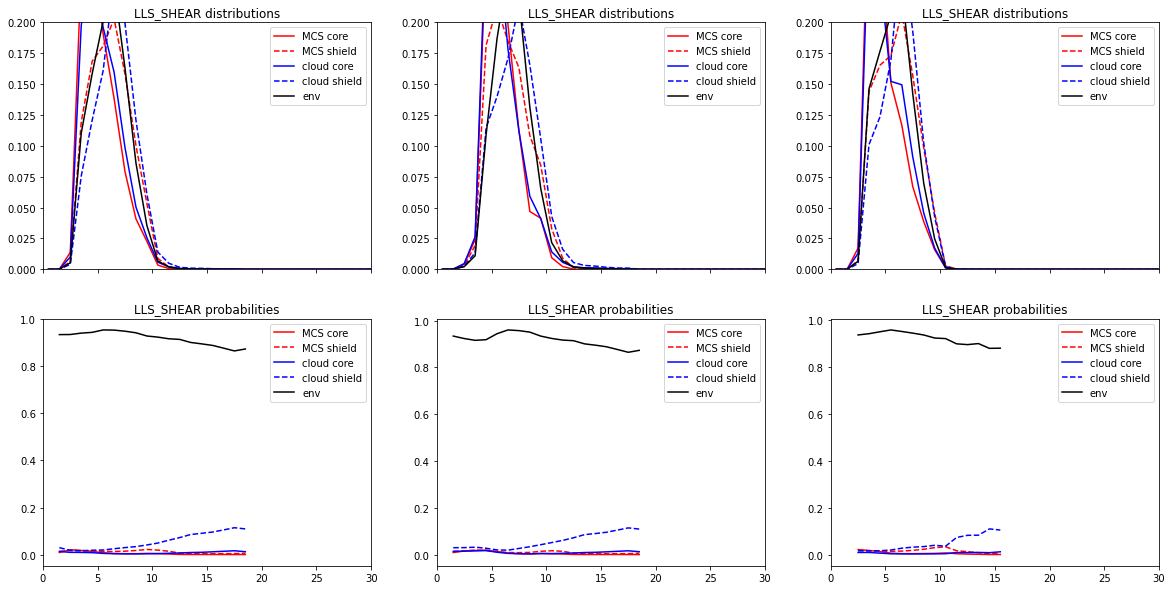

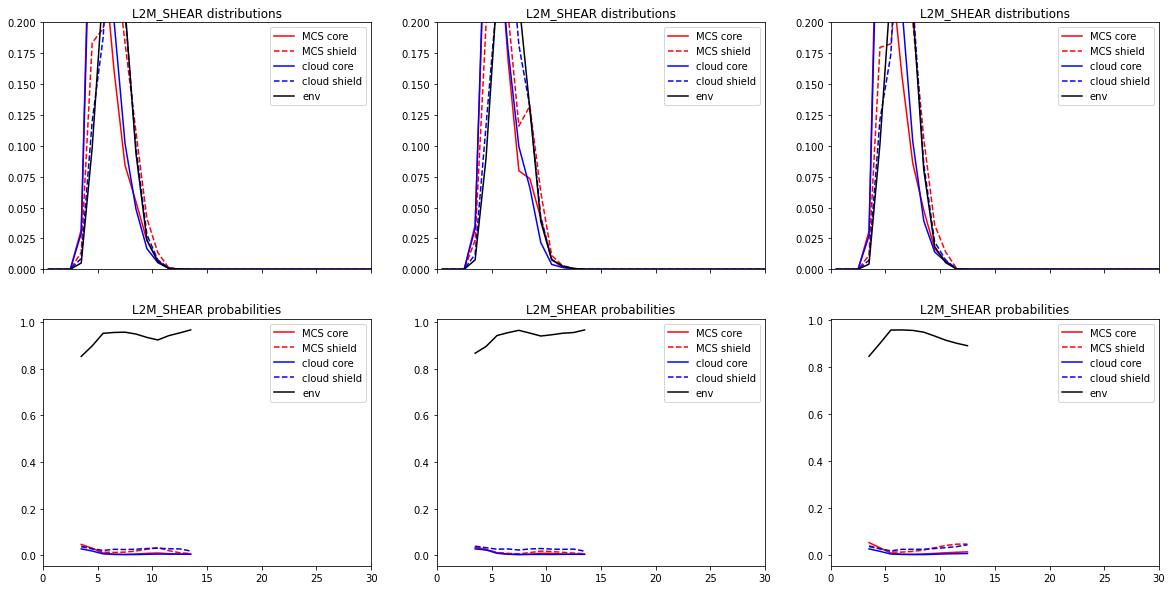

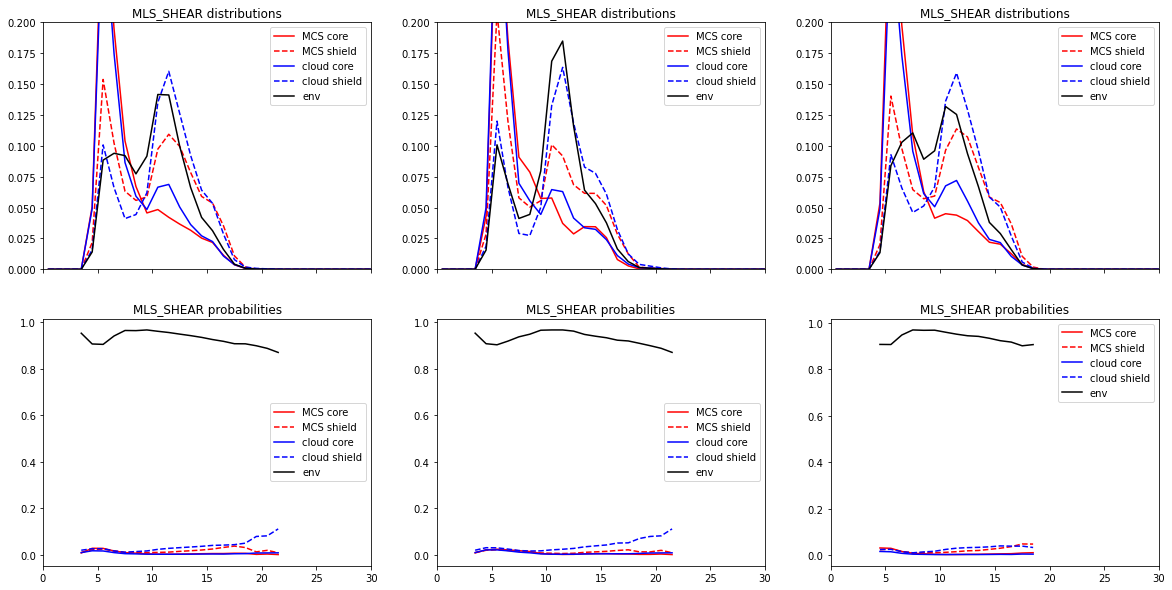

In [38]:
plot_shear(dsmf)

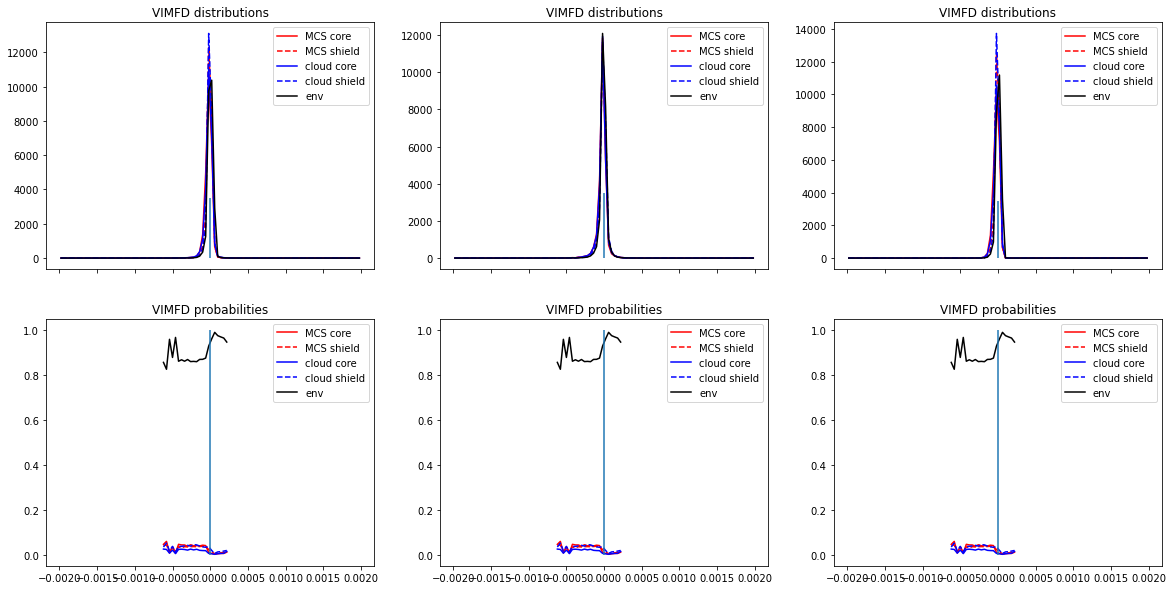

In [39]:
plot_vimfd(dsmf)